In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

## Lecture 26

- Working with data in a **NetCDF** file.
- Digital Elevation Models (DEMs).
- Working with different data layouts.
- Creating topographic transects aligned and mis-aligned to the longitude-latitude coordinate system.
- Computng the local topographic slope and drainage network.

### Topography and Digital Elevation Models (DEMs)

With the advent of modern observational techniques (e.g. InSAR), we have incredibly detailed and accurate datasets of the topography on Earth. Topographic data is typically referred to as a digital elevation model (DEM). Given a DEM, a wide variety of analysis can be conducted. In this lecture we will explore several types of simple analysis, and show you how to create profiles of topography along arbitrary transects.

### 1. Californian topography 

The National Oceanic and Atmospheric Administration (NOAA) provide numerous topography data. The NOAA data product we will use in this lecture is called ETOPO1 [https://www.ngdc.noaa.gov/mgg/global/]. 
ETOPO1 is a global dataset using a longitude and latitude resolution of 1 arc-minute.

In this lecture we will use:
* the "Bedrock" version of ETOPO1 which, in places of ice-sheets, reports the elevation at the base of the ice sheets (i.e. the elevation of the bedrock and not the ice).
* the "cell/pixel-registered" version of ETOPO1. The term "cell-registered" means that the elevation is defined as a constant over each cell / pixel in the dataset. Since each cell is 1 arc-minute in size, the dataset is comprised of a total of $21600 \times 10800$ cells in the longitude and latitude directions respectively. The ETOPO1 data provided by NOAA give the latitude in range $[-90.0,  90.0]$ and longitude in the range $[-180.0,  180.0]$.


The ETOPO1 global relief dataset is approximately 1 GB and thus too large to distribute with our GitHub repository. For the purpose of our analysis of Californian topography, I have extracted the chunk given by longitude $[-125.0, -115.0]$ and latitude $[32.0, 43.0]$. This regional chunk defines `nlon = 600` cells in longitude, `nlat = 660` cells in latitude and total number of cells (elevations), `ncells = 396000`. The file can be found here `Datasets/topo_ca.nc`.

Importantly, the data in `Datasets/topo_ca.nc` has been prepared such that the first piece of elevation data represents (lon, lat) = (-125.0, 32.0) and the last elevation data represents (lon, lat) = (43.0, -115.0). Furthermore, the second elevation recorded moves only in longitude. Longitude is associated with an $i$ direction moving from left to right, whilst latitude is associated with a $j$ direction, moving from bottom to top.

### 2. NetCDF files

The regional dataset is stored in a new type of file (as indicated by the extension `.nc`). The file type is called **NetCDF** (Network Common Data Form), and it can be opened using the Python package `netCDF4`. Let's first import this package

In [2]:
# import the new package to load NetCDF files
import netCDF4 as nc4

To open the file, we will use the method `nc4.Dataset()`. Importantly, we need to indicate that we only wish to _read_ data from the file, and we do that using the argument `'r'`.

In [3]:
etopo = nc4.Dataset("Datasets/topo_ca.nc", 'r')

Let's see what the variable `etopo` can tell us

In [4]:
print(etopo)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: ETOPO1_Bed_c_gmt4.grd [extracted CA, pits filled]
    source: grdreformat -V ETOPO1_Bed_c_gmt4.grd ETOPO1_Bed_c_gdal.grd=ci
    dimensions(sizes): 
    variables(dimensions): 
    groups: dem


`print()` displays meta-data about the file contents. NetCDF files allow embedding both meta-data (such as a title of the data, source of the data) as well as the raw data (in our case lat / lon values and elevations). Note at the bottom there is something called `groups`. A NetCDF group allows you to collect related pieces of data together. The group called `dem` is where our lat / lon / z data is living.

We can access the indiviual groups as you would a `dict`, that is we can use the key `dem` to access our data:

In [5]:
etopo_data = etopo['dem']
print(etopo_data)

<class 'netCDF4._netCDF4.Group'>
group /dem:
    dimensions(sizes): lon(600), lat(660), z(396000)
    variables(dimensions): float64 longitude(lon), float64 latitude(lat), float64 elevation(z)
    groups: 


As before we see meta-data abour the group. This group contains `variables` and `dimensions`.
The `variables` defines the names associated with each piece of data. 
The `dimensions` informs us abou the sizes of the data in the group. 

We inspect the meta-data associated with each `variable` like this

In [6]:
print('-- Meta-data for longitude --')
print(etopo_data.variables['longitude'])

print('\n-- Meta-data for latitude --')
print(etopo_data.variables['latitude'])

print('\n-- Meta-data for elevation --')
print(etopo_data.variables['elevation'])

-- Meta-data for longitude --
<class 'netCDF4._netCDF4.Variable'>
float64 longitude(lon)
    units: degrees
path = /dem
unlimited dimensions: 
current shape = (600,)
filling on, default _FillValue of 9.969209968386869e+36 used

-- Meta-data for latitude --
<class 'netCDF4._netCDF4.Variable'>
float64 latitude(lat)
    units: degrees
path = /dem
unlimited dimensions: 
current shape = (660,)
filling on, default _FillValue of 9.969209968386869e+36 used

-- Meta-data for elevation --
<class 'netCDF4._netCDF4.Variable'>
float64 elevation(z)
    units: m
path = /dem
unlimited dimensions: 
current shape = (396000,)
filling on, default _FillValue of 9.969209968386869e+36 used


You will see something very useful, the meta-data actually provides the **units** the underlying data associated with each variable is using. Very handy.

As before, we can use `dict` like key/value access patterns to retrieve the data from the file.

In [7]:
lon_1d = etopo_data.variables['longitude'][:]
lat_1d = etopo_data.variables['latitude'][:]
z = etopo_data.variables['elevation'][:]

The variables loaded have been pushed into a NumPy array

In [8]:
print(type(lon_1d))

<class 'numpy.ma.core.MaskedArray'>


When you have finished loading data from the NetCDF file, you need to close it. You do that using the `.close()` method, like this:

In [9]:
etopo.close()

## 2. Data layout

At this stage it makes sense to plot the data to see what we have loaded. We know how to do that. Since the data is cell-registered (kind of like a pixel map), we can use `plt.imshow()`. 

For the plot to make sense, let's define the bounding box we want `imshow()` to use. All the cells have the same resolution, so we can compute the delta lon delta lat and use that.

In [10]:
delta_lon = lon_1d[1] - lon_1d[0] # Difference any two values to get the delta
delta_lat = lat_1d[1] - lat_1d[0] # Difference any two values to get the delta

# Now for the bounding box. 
# We shift by 0.5 delta_{lon, lat} to define the center of each cell
lon0 = lon_1d[0]  - 0.5 * delta_lon
lon1 = lon_1d[-1] + 0.5 * delta_lon
lat0 = lat_1d[0]  - 0.5 * delta_lat
lat1 = lat_1d[-1] + 0.5 * delta_lat

bbox = lon0, lon1, lat0, lat1

Now for the figure

TypeError: Invalid shape (396000,) for image data

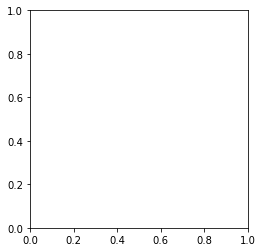

In [11]:
fig = plt.figure(frameon=False)
im1 = plt.imshow(z, extent=bbox)
fig.colorbar(im1);

That didn't work. Remember the meta-data from the NetCDF file indicated the dimension of `elevation` which we loaded into `z` was 396000, but `.imshow()` expects a two-dimensional data array. One way to get the number of points in the lon. and lat. directions is simply from the `lon_1d`, `lat_1d` arrays.

In [12]:
nlon = len(lon_1d)
nlat = len(lat_1d)

Now reshape `z` so it is two-dimensional

In [13]:
z_2d = np.reshape(z, (nlat, nlon))

Now we have correctly shaped object. In detail, `axis = 0` of `z_2d` (i.e. rows) relate to latitudes and `axis = 1` (i.e. columns) relates to longitudes.

We need to use, `origin='lower'` as `.imshow()` assumes the first piece of data lives in the top left hand corner, were as for our data the first entry is associated with the bottom-left corner. 

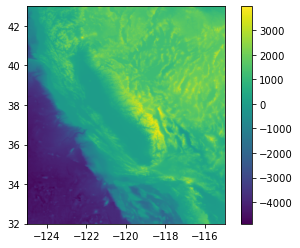

In [14]:
fig = plt.figure(frameon=False)
im1 = plt.imshow(z_2d, origin='lower', extent=bbox)
fig.colorbar(im1);

Take home message, ordering of the data matters. You need to take care you understand how data is represented in the input file you are using and understand the ordering convention / rule that has been used.

A quick inspection of the figure appear should reveal that this color palette used is not very pleasing. It is not obvious from the figure what regions are land versus water. It is customary to use a color palette which reflects this. In the next section we resolve this problem.

### 3. Topographic color palette

When visualizing topography, various standards for color maps are used. 
Specifically these standard color maps define elevations less than zero to be blue (i.e. water), and 
elevations above zero to use greens (i.e. for grass / vegetation), browns (for rock) or white (for snow / ice).
Building custom color palettes in matplotlib is possible but can be fiddly. 
One reason this is tricky is that we want the "zero" in our color palette to preserved so that a clear distinction is made between land and water.

We have created a nice palette for topograpy in the module `dem_utils`. You can access it via calling the
function `dem_utils.create_topo_cmap()` which will return a color map you can pass to matplotlib plotting functions. Let's see how it looks.

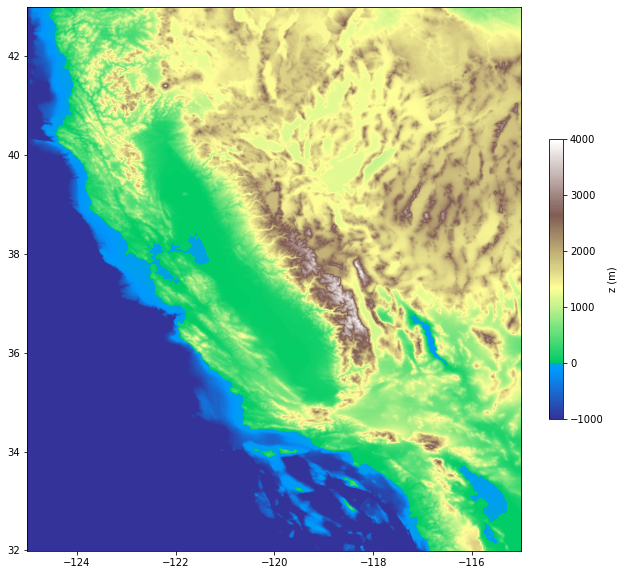

In [15]:
%matplotlib inline

import dem_utils as dem_utils

topo_cmap = dem_utils.create_topo_cmap();

fig = plt.figure(figsize=(10, 10), frameon=False);
im1 = plt.imshow(z_2d, origin='lower', extent=bbox, 
                 norm=dem_utils.FixPointNormalize(sealevel=0, vmax=4000), 
                 cmap=topo_cmap, 
                 vmin=-1000.0);
cbar = plt.colorbar(im1, fraction=0.025, label='z (m)');

You will note that this palette has been designed to give a sharp change from green to blue when the elevation is below zero.

Now that we have prepared out topographic data in a NumPy array, and can visualize it nicely, let's perform several types of analysis.

### 3. Topographic profiles

One task we would like to do is create (or extract) topographic profiles from our dataset.

Let's create two profiles, one tending north-south and another tending east-west.
Since the `z_2d` ndarray is two-dimensional and laid out in memory in terms latitrude (`axis = 0`) and longitude (`axis = 1`), we can extract the profiles directly from either a row or column of `z_2d`.

Suppose we want to create a transect at a constant longitude value of -117 degrees, or all latitudes.
To do this, we need to compute the column `index_j`  associated with `lon1 = -117`. 
We do this using the first longitude value `lon_1d[0]` and the number of degrees (in longitude direction) for each cell `delta_lon`.

In [16]:
# Profile 1
lon1 = -117.0 # Chosen longitude value
index_j = int((lon1 - lon_1d[0]) / delta_lon) # Column index

# Extract elevations for all latitudes (axis = 0 -> :) and column (axis = 1 -> index_j)
p_1 = z_2d[:, index_j]

If we wanted another profile, this time at a constant latitude of 38 degrees (`lat2 = 38`) and for all longitudes, we can follow a similar procedure. We need to compute the ow index `index_i` associated with latitude = 38 degrees. The calculation of `index_i` is performed in a similar manner and shown below.

In [17]:
lat2 = 38
index_i = int((lat2 - lat_1d[0]) / delta_lat) # Row index

# Extract elevations for all longitudes (axis = 1 -> :) and row (axis = 0 -> index_i)
p_2 = z_2d[index_i, :]

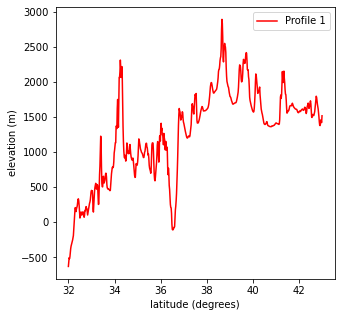

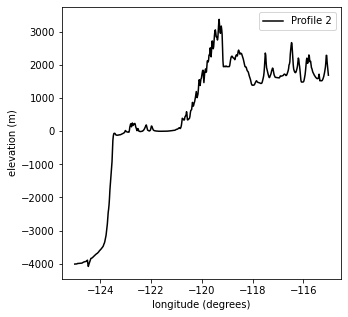

In [18]:
fig = plt.figure(figsize=(5,5))
plt.plot(lat_1d, p_1, 'r-', label='Profile 1');
plt.xlabel('latitude (degrees)')
plt.ylabel('elevation (m)')
plt.legend();

fig = plt.figure(figsize=(5,5))
plt.plot(lon_1d, p_2, 'k-', label='Profile 2');
plt.xlabel('longitude (degrees)')
plt.ylabel('elevation (m)')
plt.legend();

It might be nicer to put everything on a single plot, and also to indicate the transects on the map. 

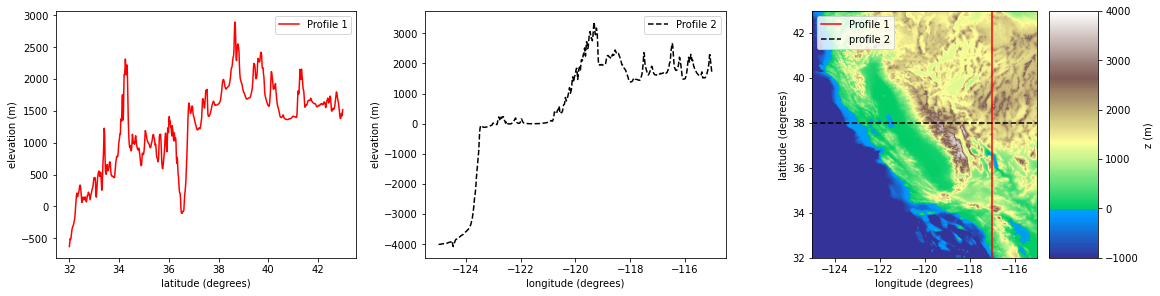

In [19]:
# Create a figure with 3 sub-plots
# constrained_layout = True ensures the axis labels don't overlap the plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

# Plot profile 1
ax1.plot(lat_1d, p_1, 'r-', label='Profile 1');
ax1.set(xlabel='latitude (degrees)', ylabel='elevation (m)')
ax1.legend();

# Plot profile 2
ax2.plot(lon_1d, p_2, 'k--', label='Profile 2');
ax2.set(xlabel='longitude (degrees)', ylabel='elevation (m)')
ax2.legend();

# Plot the map
im1 = ax3.imshow(z_2d, origin='lower', extent=bbox, 
                 norm=dem_utils.FixPointNormalize(sealevel=0, vmax=4000), 
                 cmap=topo_cmap, 
                 vmin=-1000.0);
cbar = plt.colorbar(im1, fraction=0.05, label='z (m)');

# Plot transects of profile 1 and 2 on top of the map
ax3.plot([lon1]*len(lat_1d), lat_1d, 'r-', label='Profile 1');
ax3.plot(lon_1d, [lat2]*len(lon_1d), 'k--', label='profile 2');

ax3.set(xlabel='longitude (degrees)', ylabel='latitude (degrees)')

ax3.legend();

As we have seen, extracting profiles along lines of constant longitude or latitude can be accomplished be extracting a row or column of values directly from the NumPy array storing the topography data. How should we obtain a profile if the transect does not align with the long. / lat. coordinate system? To achieve this, we have to interpolate. To interpolate topography to an arbitrary point, we will use the method `scipy.interpolate.interpn()`.

In [20]:
from scipy.interpolate import interpn as interpn

We will check we understand how `interpn()` works by first recreating one of our coordinate aligned profiles and comparing the result from `interpn()` with what we obtained before. Our comparison will be done using profile 1.

We first define a set of lat/lon coordinates which live along the profile 1 transect.
These will define the points where we will ultimately interpolate topography to.

In [21]:
# Longitude is constant lon1 = -117, we need this as an array so make a list of constant
# values and then turn it into an ndarray
transect_lon_p1 = np.array([lon1] * len(lat_1d))

# For the lats, simply copying the 1-D array we have
transect_lat_p1 = np.copy(lat_1d)

To use `interpn()` we need to provide the 1-D arrays of longitudes and latitudes associated with the map. We will call that variables `points`, and simply pack the 1-D arrays into a tuple:

In [22]:
points = (lon_1d, lat_1d)

Now to perform the interpolation of topography at all coorindates defined by `(transect_lon_p1, transect_lat_p1)` we do this 

In [23]:
transect_vals = interpn(points, z_2d.T, (transect_lon_p1, transect_lat_p1), bounds_error=True)

Note that we do have to transpose the `z_2d` array. The argument `bounds_error = True` is useful and will report an error if you try to perform interplate at lat. / lon. values outside of the range given by `lon_1d, lat_1d`. Let's plot the new transect with the old transect as a sanity check.

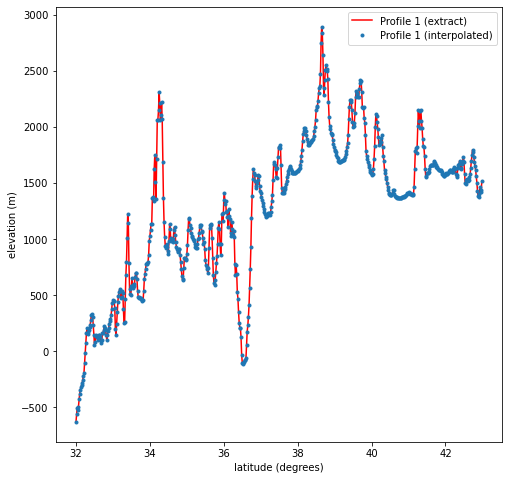

In [24]:
fig = plt.figure(figsize=(8, 8))
plt.plot(lat_1d, p_1, 'r-', label='Profile 1 (extract)');
plt.plot(transect_lat_p1, transect_vals, '.', label='Profile 1 (interpolated)');
plt.xlabel('latitude (degrees)')
plt.ylabel('elevation (m)')
plt.legend();

Great, they look the same. Let's move on to defining a transect not aligned with the lat. lon. coordinate system.
We first define the end points of the transect $\mathbf p_1, \mathbf p_2$ and assign them the variable names `point_1` and `point_2`:

In [25]:
point_1 = (-122.0, 36.0)
point_2 = (-118.0, 41.0)

We now choose a number of points along the transect $(\mathbf p_1, \mathbf p_2)$ we wish to sample the topography at. We use this to define two 1-D arrays of latitudes and longitudes we will pass to `interpn()`.

In [26]:
nsample = 132
transect_lon = np.linspace(point_1[0], point_2[0], nsample, endpoint=True) # lons
transect_lat = np.linspace(point_1[1], point_2[1], nsample, endpoint=True) # lats

Now perform the interpolation of elevation to the points defining the transect `(transect_lon, transect_lat)`:

In [27]:
transect_vals = interpn(points, z_2d.T, (transect_lon, transect_lat), method='linear', bounds_error=True)

The argument `method` can be either `'nearest'`, `'linear'` or `'splinef2d'`.

As before, we plot the profile next to the map showing the location of the transect. 
We do have to think about what quantity should be used for "distance" along the horizontal axis (x axis) in our elevation profile (left panel) plot.
In the plot below, I have used longitude.

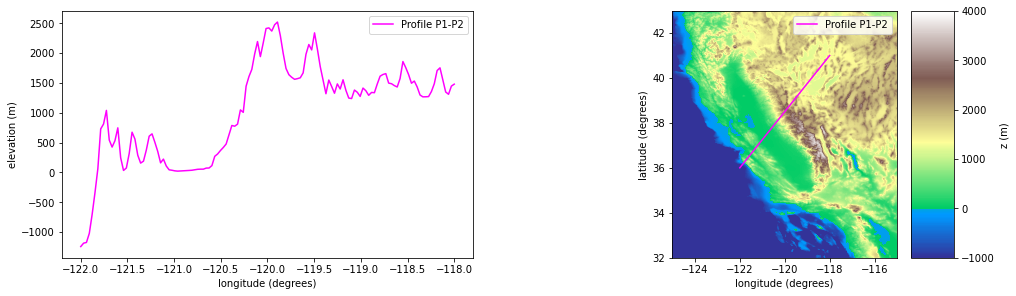

In [28]:
# Create a figure with 2 sub-plots
# constrained_layout = True ensures the axis labels don't overlap the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# Plot profile 
ax1.plot(transect_lon, transect_vals, c='magenta', label='Profile P1-P2');
ax1.set(xlabel='longitude (degrees)', ylabel='elevation (m)')
ax1.legend();

# Plot the map
im1 = ax2.imshow(z_2d, origin='lower', extent=bbox, 
                 norm=dem_utils.FixPointNormalize(sealevel=0, vmax=4000), 
                 cmap=topo_cmap, 
                 vmin=-1000.0);
cbar = plt.colorbar(im1, fraction=0.05, label='z (m)');

# Plot transects of the profile on top of the map
ax2.plot(transect_lon, transect_lat, c='magenta', label='Profile P1-P2');

ax2.set(xlabel='longitude (degrees)', ylabel='latitude (degrees)')
ax2.legend();

Can you think of a more suitable quantity to be used along the horizontal (x) axis of the elvation plot? How would you compute this quantity?

### 4. Slope analysis

Given a high-resolution DEM, it is or interest to examine the local topographic slope. 
Recall that our DEM is define a structured grid, where every cell, with the exception of those on the boundary, have eight neighbor cells. For a given cell, we will use its elevation and the elevation of its eight neighbors to define a local estimate of the topographic slope.

Here we will measure the local "down-stream slope". Given a cell $c$ the elevation of cell $e_c$, we compute the neighbor cell $n$ which has (i) an elevation $e_n < e_c$ and (ii) has the minimum elevation of all neighbors.
The down-stream slope (a strictly positive quantity) is defined as
$$
    S = \frac{e_c - e_n}{\Delta L}.
$$

The module `dem_utils` defines two helpful functions, the first `get_cell_neighbors_cart()` determines the cell indices of all neighbor cells, the second is `determine_receiver()` which computes which neighbor cell index has the lowest elevation. Note that `determine_receiver()` works with the "flat" array `z` and not the 2-D dimensional form `z_2d`.

In [29]:
# Compute the indices of the neighboring 8 cells
cell_neighbors = dem_utils.get_cell_neighbors_cart(nlon, nlat)

# Compute the neighbor cell with the lowest elevation
recv = dem_utils.determine_receiver(cell_neighbors, z)

For a given cell `c`, the value of `recv[c]` gives you the index of the neighbor cell with the lowest elevation. A value of `-1` indicates that cell `c` does not have a neighbor cell which is lower than it.

The slope calculation requires a distance / length $\Delta L$ be computed. We cheat here and approximating distance by converting degrees (as measured on the surface of the Earth) into km. The approximation we will use is that 1 degree is approximately equal to 111.32 km. It is an "ok" approximation at the equator. If you were to compute the slope in your research you should do a more accurate job!

Let's create a grid of x, y coordinates to use for compute $\Delta L$.

In [30]:
xdem = np.zeros(nlon * nlat)
ydem = np.zeros(nlon * nlat)

# Create a grid of lon / lat values using i, j indices, 
# the first lon / lat value and the size in degrees of each cell.
for i in range(nlon):
    for j in range(nlat):
        xdem[i + j*nlon] = lon_1d[0] + i * delta_lon
        ydem[i + j*nlon] = lat_1d[0] + j * delta_lat

# Shift coordinates relative the first lon/lat value.
xdem -= lon_1d[0]
ydem -= lat_1d[0]

# 1 degree ~ 111.32 km (at the equator).
# Scale all coordinates by 111.32 km.
xdem *= 111.32 * 1.0e3
ydem *= 111.32 * 1.0e3

Now compute the slope.

In [31]:
# Initialize the array to store the down-stream slope.
ncells = nlon * nlat
slope = np.zeros(ncells)

In [32]:
# Traverse through all cells
# The value of recv[c] gives you the index of the neighbor cell with the lowest elevation.
# Cells for which recv[c] == -1 have zero slope, i.e. there are no cells down-strea of it.
for c in range(ncells):
    height_high = z[c]
    if recv[c] != -1:
        height_low = z[recv[c]]
        dL = np.sqrt((xdem[c] - xdem[recv[c]])**2 + (ydem[c] - ydem[recv[c]])**2)
        slope[c] = (height_high - height_low) / dL
slope = np.arctan(slope)
slope = np.degrees(slope)

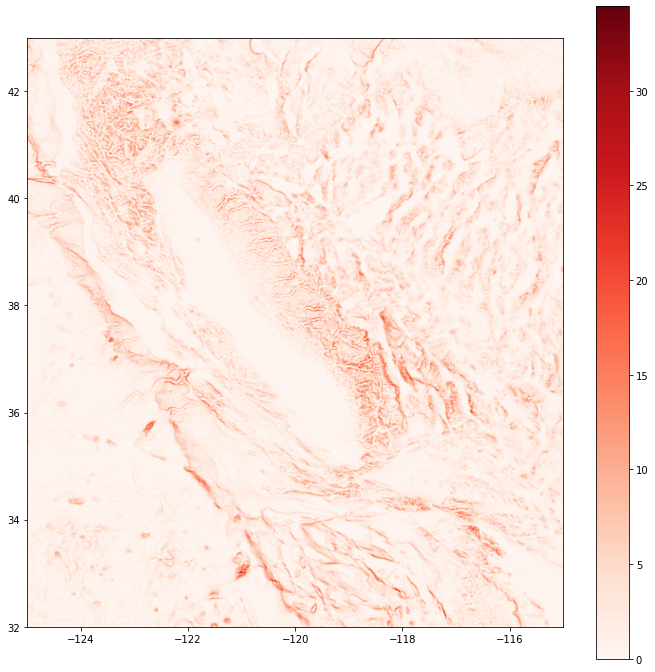

In [33]:
fig = plt.figure(figsize=(12, 12), frameon=False)
im1 = plt.imshow(np.reshape(slope, (nlat, nlon)), origin='lower', extent=bbox, cmap='Reds')
fig.colorbar(im1);

### 5. Drainage network

One can use a DEM to delineate a drainage network associated with a region (O' Callaghan & Mark, 1984).
The analysis is quite simple and essentially revolves around the assumption that
water flows down hill and preferentially in the direction where the local
slope is largest.

Here we will use flow direction known as "D8" to infer a drainage network.
The ingredients needed are provided in the module `dem_utils` and include the
functions `.get_cell_neighbors_cart()`, `.determine_receiver()` and `.flow_accumulate()`.

Given a DEM, the D8 algorithm is decomposed into several stages:
1. Compute the neighbors of all cells;
2. Compute the cell neighor with the lowest elevation for each cell;
3. Compute the flow direction;
4. Accumulate "information" in a down-stream direction.

Points 1 and 2 have been discussed earlier. 
For point 3, the down-stream direction is simply defined as being one of the eight possible 
directions: north, south, east, west, north-east, south-west, north-west, south-east, and is determined
by the neighbor cell with the lowest elevation.
Step 4 needs further explanation. The term "accumulate" simply means "sum" (i.e. add).
The term "information" in our case will mean "number of cells upstream".
In essence, what we are trying to compute is for a given cell `c`, how many cells drain (upstream) drain in to it. The higher this number, the more likely this cell will form part of a river.

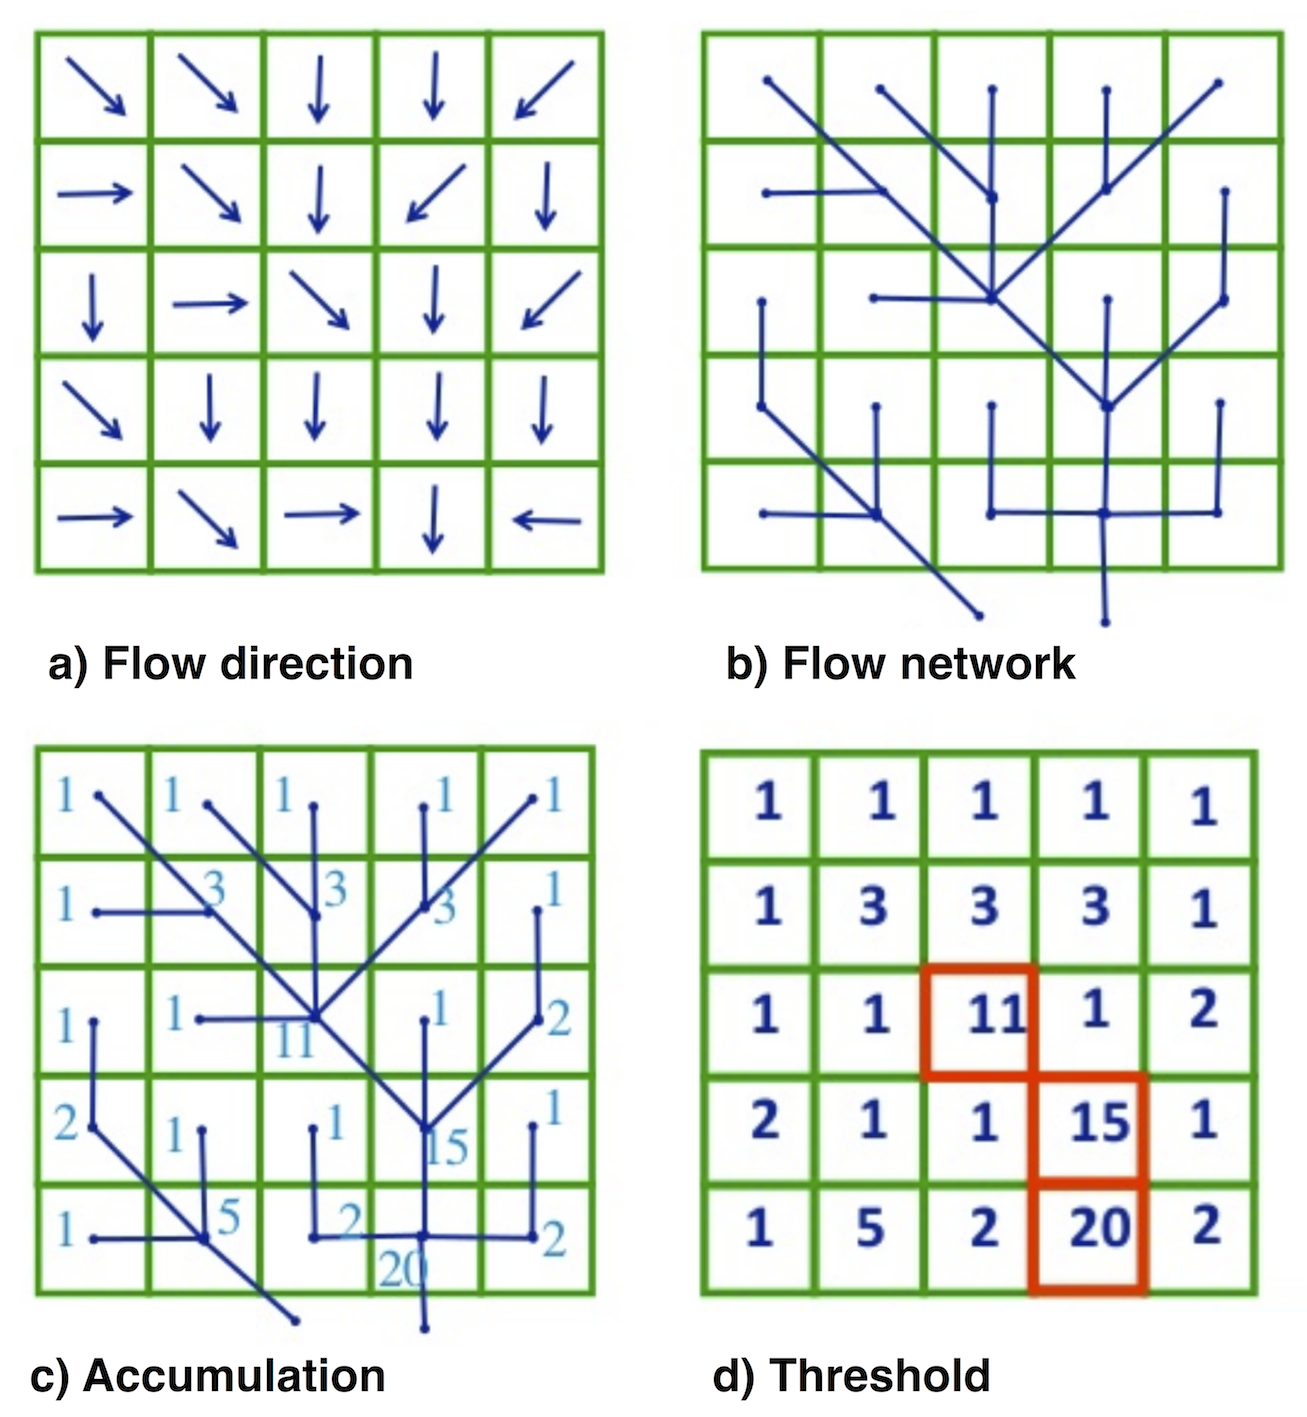

In [34]:
Image(filename='Figures/DEM-D8.png', width=400)

*Illustration of the different stages of the D8 algorithm used to delineate a drainage network. a) The flow directions point in the direction of the neighbor cell with the lowest elevation. b) The network is computed by connecting cells with their down-stream neighbor. c) The result of accumulating (summing) the value of 1.0 is shown. It is important to note that each cell "accumulates" information from itself and not only upstream cells. d) Given a cell count threshold of 10, the stream network is defined by the connecting cells centers associated with cells shown in red.*

Let's compute the drainage network. First (as before), we compute the neighbor cell indices and the neighbor with the minimum elevation (steps 1, 2). This implicitly also gives us the flow direction (step 3).

In [35]:
# Compute the indices of the neighboring 8 cells
cell_neighbors = dem_utils.get_cell_neighbors_cart(nlon, nlat)

# Compute the neighbor cell with the lowest elevation
recv = dem_utils.determine_receiver(cell_neighbors, z)

Now we call `dem_utils.flow_accumulate()` to sum the value of 1.0 down through our newtwork (step 4):

In [36]:
# Accumulate / count the cells upstream
upstream_count = dem_utils.flow_accumulate(recv, z)

We can visualize the drainage network by examining the resulting ndarray `upstream_count`.
Before visualizing the network, we want to modify the upstream cell count values in a several ways.
First, to highlight the network we will plot the $\log_{10}$ of the cell counts.
Second, we do not want to examine the drainage network within the water (i.e. those with elevation < 0), so we will set those cell counts with an upstream cell count equal to 1.0 (meaning no cell drains into them).

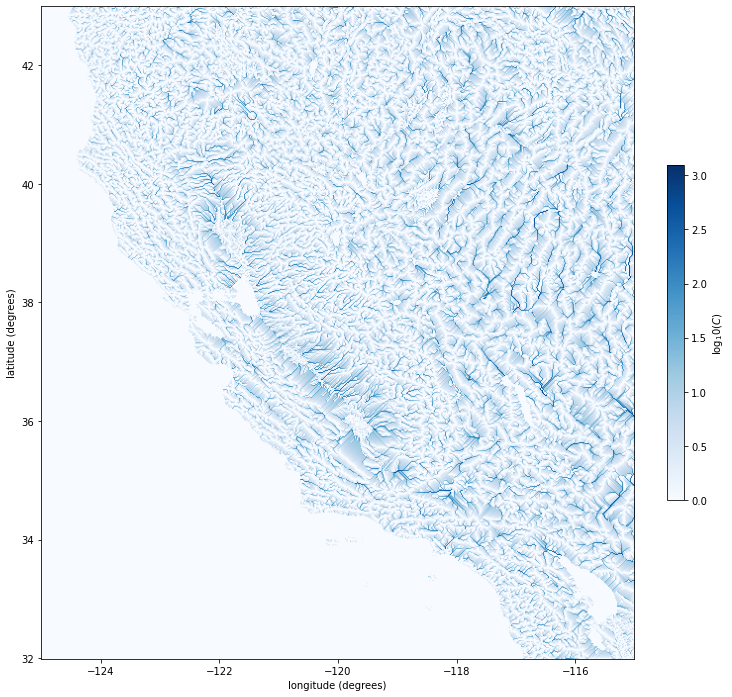

In [37]:
# Copy the accumulated cell count
accumulate_target = np.copy(upstream_count)

# Set all cells in the water to have an upstream-cell count of 1.0
accumulate_target[ z <= 0.0 ] = 1.0

# Compute the log10 of the result
accumulate_target = np.log10(accumulate_target)

fig = plt.figure(figsize=(12,12),frameon=False)
im1 = plt.imshow(np.reshape(accumulate_target, (nlat, nlon)), origin='lower', extent=bbox, cmap='Blues')
cbar = plt.colorbar(im1, fraction=0.025, label='$\log_10(C)$');
plt.xlabel('longitude (degrees)');
plt.ylabel('latitude (degrees)');

Another way to visualize the newtwork is to only plot cells with an upstream cell count greater than some threshold value. We will define this parameter as `threshold` and assign (somehwat arbitrarily) a value of 20.
We will then create a mask `mask_target` in which all cells in the water, or with an upstream count less than `threshold` have a value of 0, and all other cells have a value of 1.0. 
Then using a binary color palette the river network is more visible.

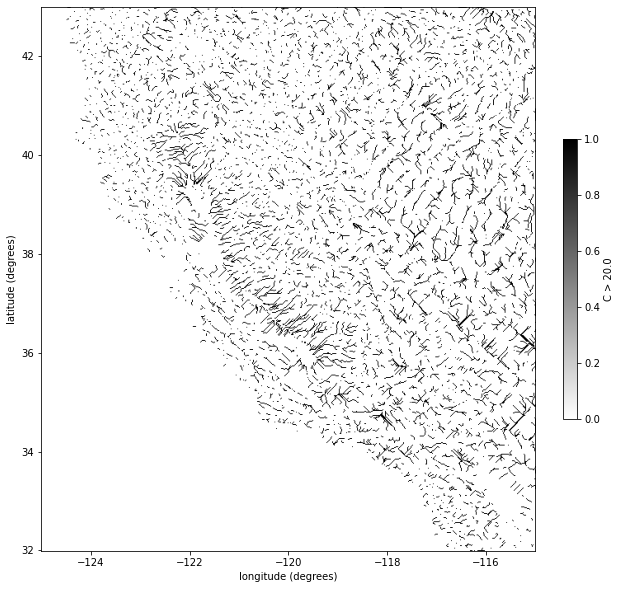

In [38]:
# Copy upstream cell count
mask_target = np.copy(upstream_count)

# Set a threshold (arbitrary)
threshold = 20.0

# Mask based on upstream cell count and elevation
mask_target[ upstream_count >= threshold ] = 1
mask_target[ upstream_count < threshold ] = 0
mask_target[ z <= 0.0 ] = 0

fig = plt.figure(figsize=(10,10),frameon=False)
im1 = plt.imshow(np.reshape(mask_target, (nlat, nlon)), origin='lower', extent=bbox, cmap='binary')
cbar = plt.colorbar(im1, fraction=0.025, label='C > ' + str(threshold));
plt.xlabel('longitude (degrees)');
plt.ylabel('latitude (degrees)');

### References

* National Oceanic and Atmospheric Administration (NOAA) ETOPO1 dataset: https://www.ngdc.noaa.gov/mgg/global
* NetCDF website: https://www.unidata.ucar.edu/software/netcdf
* NetCDF tutorial: https://www.unidata.ucar.edu/software/netcdf/docs/tutorial_8dox.html#sec_tut
* O'Callaghan, John F., and David M. Mark. "The extraction of drainage networks from digital elevation data." Computer vision, graphics, and image processing 28, no. 3 (1984): 323-344